# Atmospheric models

In this tutorial, we will have a look at some spectra of the DRIFT-PHOENIX atmospheric model. The spectra are first downloaded and added to the database. Then we will use the functionalities of [ReadModel](https://species.readthedocs.io/en/latest/species.read.html?highlight=ReadModel#species.read.read_model.ReadModel) to extract a spectrum and calculate a photometric flux.

## Getting started

We start by importing the required Python modules.

In [1]:
import species
from IPython.display import Image

Then we initialize [species](https://species.readthedocs.io/en/latest/species.html) with [SpeciesInit](https://species.readthedocs.io/en/latest/species.core.html#species.core.setup.SpeciesInit), which creates a default configuration file and the HDF5 database.

In [2]:
species.SpeciesInit()

Initiating species v0.3.1... [DONE]
Creating species_config.ini... [DONE]
Database: /Users/tomasstolker/applications/species/docs/tutorials/species_database.hdf5
Data folder: /Users/tomasstolker/applications/species/docs/tutorials/data
Working folder: /Users/tomasstolker/applications/species/docs/tutorials
Creating species_database.hdf5... [DONE]
Creating data folder... [DONE]


## Adding model spectra to the database

To store the spectra, we first create an instance of [Database](https://species.readthedocs.io/en/latest/species.data.html?highlight=database.Database#species.data.database.Database).

In [3]:
database = species.Database()

Next, we will import the model spectra with the [add_model](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.add_model) method of [Database](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database). This step will automatically download the DRIFT-PHOENIX spectra (R = 2000) to the [data_folder](https://species.readthedocs.io/en/latest/configuration.html). The dowloaded data will then be unpacked and added to the database. We restrict the temperature range to 1300-1700 K, so not all spectra are added to the databse.

In [4]:
database.add_model(model='drift-phoenix', teff_range=(1300., 1700.))

Unpacking DRIFT-PHOENIX model spectra (229 MB)... [DONE]
Adding DRIFT-PHOENIX model spectra... [DONE]                                            
Grid points stored in the database:
   - Teff = [1300. 1400. 1500. 1600. 1700.]
   - log(g) = [3.  3.5 4.  4.5 5.  5.5]
   - [Fe/H] = [-0.6 -0.3 -0.   0.3]
Number of grid points per parameter:
   - teff: 5
   - logg: 6
   - feh: 4
Fix missing grid points with a linear interpolation:
   - teff = 1600.0, logg = 3.0, feh = 0.3
   - teff = 1600.0, logg = 5.5, feh = 0.3
Number of stored grid points: 120
Number of interpolated grid points: 2
Number of missing grid points: 0


/Users/tomasstolker/applications/species/species/util/data_util.py:268: RuntimeWarning: divide by zero encountered in log10
  flux = np.log10(flux)


Two of the grid points were missing in the original data and have been added with a linear, multidimensional interpolation.

## Interpolating the model grid

We will read the spectra from the database by creating an instance of [ReadModel](https://species.readthedocs.io/en/latest/species.read.html#species.read.read_model.ReadModel).

In [5]:
read_model = species.ReadModel(model='drift-phoenix', wavel_range=(0.5, 10.))

Let's see what the grid boundaries are from the spectra that are stored in the database.

In [6]:
read_model.get_bounds()

{'teff': (1300.0, 1700.0), 'logg': (3.0, 5.5), 'feh': (-0.6, 0.3)}

We will now interpolate the grid in the (Teff, log(g), \[Fe/H\]) space at some specific parameter values, which need to be provided in a dictionary. The radius and distance are optional, otherwise the emitted flux is given at the planet surface.

In [7]:
model_param = {'teff':1510., 'logg':4.1, 'feh':0.1, 'radius': 1., 'distance': 100.}

To interpolate a spectrum, we use the [get_model](https://species.readthedocs.io/en/latest/species.read.html#species.read.read_model.ReadModel.get_model) method and provide the parameter dictionary, and also an optional spectral resolution. Together with `smooth=True`, the spectrum will be smoothed (but not resampeld) to the given spectral resolution.

In [8]:
modelbox = read_model.get_model(model_param=model_param, spec_res=200., smooth=True)

The data is stored in a [ModelBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ModelBox). Let's have a look at its content.

In [9]:
modelbox.open_box()

Opening ModelBox...
model = drift-phoenix
type = None
wavelength = [ 0.49989727  0.50002105  0.50014486 ...  9.99710369  9.99957902
 10.00205496]
flux = [9.44339097e-20 9.38011967e-20 9.31147817e-20 ... 1.53571943e-18
 1.53924349e-18 1.54301688e-18]
parameters = {'teff': 1510.0, 'logg': 4.1, 'feh': 0.1, 'radius': 1.0, 'distance': 100.0, 'mass': 4.857062223118246, 'luminosity': 4.729862212008143e-05}
quantity = flux


We will now use the same atmospheric parameters but we will add some [ISM extinction](https://species.readthedocs.io/en/latest/species.util.html?#species.util.dust_util.ism_extinction) with the relation from [Cardelli et al. (1989)](https://ui.adsabs.harvard.edu/abs/1989ApJ...345..245C/abstract). Therefore, we add the V band extinction and reddening parameters to the dictionary.

In [10]:
model_param = {'teff':1510., 'logg':4.1, 'feh':0.1, 'radius': 1., 'distance': 100., 'ism_ext': 5., 'ism_red': 3.}

We use again the [get_model](https://species.readthedocs.io/en/latest/species.read.html#species.read.read_model.ReadModel.get_model) method and store the result in a different [ModelBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ModelBox).

In [11]:
model_ext = read_model.get_model(model_param=model_param, spec_res=200., smooth=True)

The two boxes with the model spectra are provided to the [plot_spectrum](https://species.readthedocs.io/en/latest/species.plot.html#species.plot.plot_spectrum.plot_spectrum). We also include some filter profiles to indicate where the telluric windows are.

In [12]:
species.plot_spectrum(boxes=[modelbox, model_ext],
                      filters=['MKO/NSFCam.J', 'MKO/NSFCam.H', 'MKO/NSFCam.K', 'MKO/NSFCam.Lp', 'MKO/NSFCam.Mp'],
                      offset=(-0.08, -0.04),
                      xlim=(0.8, 5.),
                      ylim=(0., 5.5e-17),
                      legend={'loc': 'lower right', 'frameon': False, 'fontsize': 12.},
                      output='model_spectrum.png')

Adding filter: MKO/NSFCam.J... [DONE]
Adding filter: MKO/NSFCam.H... [DONE]
Adding filter: MKO/NSFCam.K... [DONE]
Adding filter: MKO/NSFCam.Lp... [DONE]
Adding filter: MKO/NSFCam.Mp... [DONE]
Plotting spectrum: model_spectrum.png... [DONE]


Let's have a look at the result!

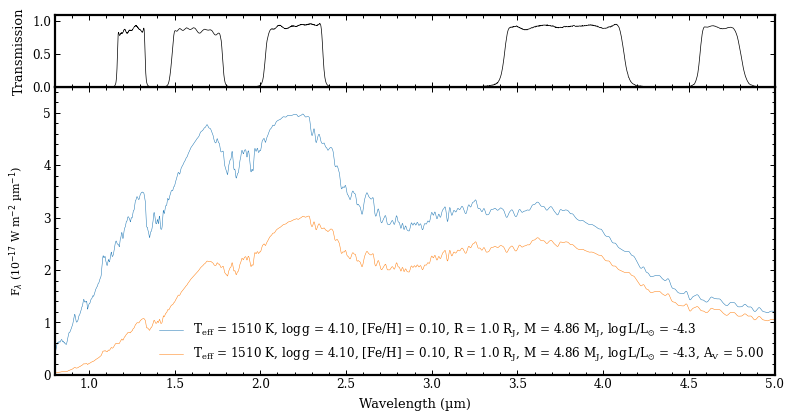

In [13]:
Image('model_spectrum.png') 

## Extracting a spectrum at a grid point

It is also possible to extract a spectrum at one of the grid points, which doesn't require any interpolation. Let's first check with the [get_points](https://species.readthedocs.io/en/latest/species.read.html#species.read.read_model.ReadModel.get_points) method what parameter values are stored in the database.

In [14]:
read_model.get_points()

{'teff': array([1300., 1400., 1500., 1600., 1700.]),
 'logg': array([3. , 3.5, 4. , 4.5, 5. , 5.5]),
 'feh': array([-0.6, -0.3, -0. ,  0.3])}

We create a dictionary with values at one of the grid points.

In [15]:
model_param = {'teff':1500., 'logg':4., 'feh':0.}

And now use the [get_data](https://species.readthedocs.io/en/latest/species.read.html#species.read.read_model.ReadModel.get_data) method to extract a spectrum.

In [16]:
modelbox = read_model.get_data(model_param)

Let's make another plot with [plot_spectrum](https://species.readthedocs.io/en/latest/species.plot.html#species.plot.plot_spectrum.plot_spectrum).

In [17]:
species.plot_spectrum(boxes=[modelbox],
                      filters=None,
                      offset=(-0.1, -0.05),
                      xlim=(0.8, 5.),
                      ylim=(0., 1e5),
                      legend={'loc': 'upper right', 'frameon': False, 'fontsize': 12.},
                      figsize=(8., 3.),
                      output='model_spectrum.png')

Plotting spectrum: model_spectrum.png... [DONE]


The spectrum is now shown at the spectral resolution as stored in the database (R = 2000).

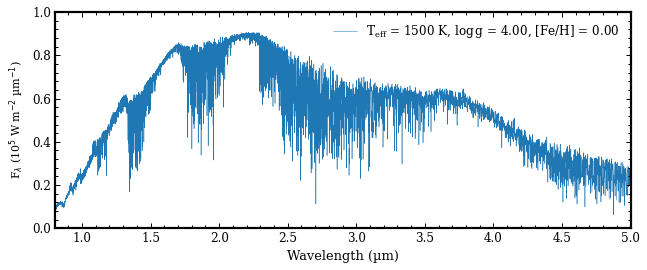

In [18]:
Image('model_spectrum.png')

## Calculating synthetic photometry

The [ReadModel](https://species.readthedocs.io/en/latest/species.read.html?highlight=ReadModel#species.read.read_model.ReadModel) class can also be used for calculating photometric fluxes and magnitudes. To do so, we create a new instance and set the `filter_name` argument to the [VLT/NACO M' filter](http://svo2.cab.inta-csic.es/svo/theory/fps/index.php?id=Paranal/NACO.Mp&&mode=browse&gname=Paranal&gname2=NACO#filter). This will automatically downloadd and addd the filter profile. 

In [19]:
read_model = species.ReadModel(model='drift-phoenix', filter_name='Paranal/NACO.Mp')

Adding filter: Paranal/NACO.Mp... [DONE]


We create again a dictionary with the parameters but now run the [get_flux](https://species.readthedocs.io/en/latest/species.read.html?highlight=ReadModel#species.read.read_model.ReadModel.get_flux) method, which returns the flux in W m-2 um-1.

In [20]:
model_param = {'teff':1510., 'logg':4.1, 'feh':0.1, 'radius': 1., 'distance': 100.}
flux = read_model.get_flux(model_param)
print(f'Flux (W m-2 um-1) = {flux[0]:.2e}')

Flux (W m-2 um-1) = 1.33e-17


Since we provided a radius and distance, the emitted flux at the planet surface has been scaled by (radius/distance)$^2$.

Similarly, we can use the [get_magnitude](https://species.readthedocs.io/en/latest/species.read.html?highlight=ReadModel#species.read.read_model.ReadModel.get_magnitude) method to calculate the magnitude for the NACO M' filter. Note that the returned absolute magnitude is set to `None` if the parameter dictionary does not contain a radius and distance.

In [21]:
app_mag, abs_mag = read_model.get_magnitude(model_param)
print(f'Apparent magnitude = {app_mag:.2f}')
print(f'Absolute magnitude = {abs_mag:.2f}')

Adding Vega spectrum... [DONE]
Apparent magnitude = 15.53
Absolute magnitude = 10.53


As expected, at a distance of 100 pc, the difference between the apparent and absolute magnitude is 5.